# Introdução

Neste projeto, implementaremos uma rede neural de 3 camadas para reconhecer dígitos do conjunto de dados MNIST.

Durante a implementação da rede neural, variaremos os hiperparâmetros para testar qual combinação de hiperparâmetros oferece o melhor desempenho.

Os hiperparâmetros que iremos variar serão:

1) O número de unidades na camada oculta:
	- 25 unidades
	- 50 unidades
	- 100 unidades
2) O algoritmo de gradiente descendente usado:
	- Gradiente Descendente: o gradiente é calculado após cada época (após o processamento dos 5000 inputs de treinamento)
	- Gradiente Descendente Estocástico: o gradiente é calculado após cada input (após o processamento de um único input de treinamento)
	- Mini-Batch: o gradiente é calculado após b inputs (após o processamento de b inputs de treinamento)
		1) b = 10
		2) b = 50
3) A taxa de aprendizado:
	- 0.5
	- 1
	- 10

Para cada combinação desses hiperparâmetros (número de unidades ocultas, algoritmo de gradiente descendente e taxa de aprendizado), avaliaremos seu desempenho e sua convergência para o erro empírico (em gráficos).


# Setup

## Importando bibliotecas necessárias

Aqui faremos os imports necessários:

In [371]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, random_split
import matplotlib.pyplot as plt
import pickle
import itertools

## Carregando dados

Aqui carregaremos nossos dados de um arquivo csv para um pandas Dataframe:

In [372]:
file_path = 'data_tp1'
data = pd.read_csv(file_path, header=None)
data.rename(columns={0: 'y'}, inplace=True)
shuffled_data = data.sample(frac=1)

shuffled_data

,y,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
89,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4017,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1554,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3571,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3467,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3955,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2870,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3175,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Observe que cada linha corresponde a um dígito rotulado (um exemplo) dos dados de treinamento.

A primeira coluna (y) é o rótulo do dígito da imagem (variando de 0 a 9), e as 784 colunas restantes são os valores de escala de cinza (variando de 0 a 255) de cada pixel da imagem.

Agora nós separaremos os inputs dos seus respectivos labels e concomitantement normalizar os dados.

In [373]:
X = shuffled_data.drop('y', axis=1).values.astype('float32') / 255
y = shuffled_data['y'].values

Agora, vamos converter os inputs e labels para pytorch tensors:

In [374]:
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)

print(X_tensor.shape, y_tensor.shape[0])

torch.Size([5000, 784]) 5000


## Separando os dados em dado de treino, validação e teste

Aqui vamos separar os dados em dado de treino, validação e teste

In [375]:
dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# A rede neural

Aqui implementaremos a rede neural utilizado pytorch

In [376]:
class NeuralNetwork(nn.Module):
	def __init__(self, input_size, hidden_size, output_size):
		super().__init__()
		self.full_con_layer_1 = nn.Linear(input_size, hidden_size)
		self.sigm = nn.Sigmoid()
		self.full_con_layer_2 = nn.Linear(hidden_size, output_size)
		
	def forward(self, input):
		input_lin_comb = self.full_con_layer_1(input)
		layer_1_output = self.sigm(input_lin_comb)
		layer_2_output = self.full_con_layer_2(layer_1_output)
		return layer_2_output


# Treinando a rede neural com diferentes hiperparâmetros

Primeiro, vamos criar uma função que avaliará o desempenho de um modelo, dada uma função de perda e dados. Isso será usado para avaliar o desempenho do modelo que obtivermos após cada época de treinamento.

In [377]:
def eval_neural_net(model, loss_func, data_loader):
	model.eval()
	loss = 0
	correct = 0
	total = 0
	with torch.no_grad():
		for data, target in data_loader:
			output = model(data)
			loss += loss_func(output, target).item()
			_, prediction = torch.max(output.data, 1)
			total += target.size(0)
			correct += (prediction == target).sum().item()
	return loss / len(data_loader), correct / total

Agora criaremos uma função para treinar o model

In [378]:
def train_neural_net(model, train_dataloader, loss_func, optimizer, num_epochs, val_dataloader):
	
	model.train()

	train_losses = []
	valid_losses = []
	valid_accuracies = []

	for i in range(num_epochs):
		epoch_loss = 0
		for data, target in train_dataloader:
			optimizer.zero_grad()
			# Forward pass
			outputs = model(data)
			# Loss calculation
			loss = loss_func(outputs, target)
			# Backward pass and parameter update
			loss.backward()
			optimizer.step()
			epoch_loss += loss.item()

		avg_epoch_loss = epoch_loss / len(train_dataloader)	
		train_losses.append(avg_epoch_loss)
		valid_loss, val_accuracy = eval_neural_net(model, loss_func, val_dataloader)
		valid_losses.append(valid_loss)
		valid_accuracies.append(val_accuracy)
		

	return train_losses, valid_losses, valid_accuracies


Aqui treinaremos os modelos com diferentes hiperparâmetros para depois compararmos a performance de cada um:

In [ ]:
# Below are the hyperparameters to be tested	
num_hidden_units_options = [25, 50, 100]
batch_size_options = [1, 10, 50, 5000]
learning_rate_options = [0.5, 1, 10]
num_epochs = 100

total_neural_nets = len(num_hidden_units_options) * len(batch_size_options) * len(learning_rate_options)

train_results = {}

train_count = 1
for num_hidden_units in num_hidden_units_options:
	for batch_size in batch_size_options:
		for learning_rate in learning_rate_options:
			model = NeuralNetwork(784, num_hidden_units, 10)
			loss_func = nn.CrossEntropyLoss()
			optimizer = optim.SGD(model.parameters(), lr=learning_rate)
			train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
			valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
			print(f'Training neural net {train_count} with: {num_hidden_units} hidden units, a learning rate of {learning_rate}, and a batch size of {batch_size}...')
			train_losses, valid_losses, valid_accuracies = train_neural_net(model, train_dataloader, loss_func, optimizer, num_epochs, valid_dataloader)
			print(f'Finished training neural net {train_count}, {total_neural_nets - train_count} neural nets left to train...')
			train_count += 1
			train_result = {
				'num_hidden_units': num_hidden_units,
				'batch_size': batch_size,
				'learning_rate': learning_rate,
				'train_losses': train_losses,
				'valid_losses': valid_losses,
				'valid_accuracies': valid_accuracies
			}
			train_results[(num_hidden_units, batch_size, learning_rate)] = train_result
			with open("results/2train_results.pkl", "wb") as f:
				pickle.dump(train_results, f)

# Análise

Aqui compararemos os diferentes models que treinamos anteriormente. Primeiro, vamos carregar os resultados:

In [380]:
with open("results/train_results.pkl", "rb") as f:
	train_results = pickle.load(f)

## Plotando os resultados

Agora vamos plotar os resultados

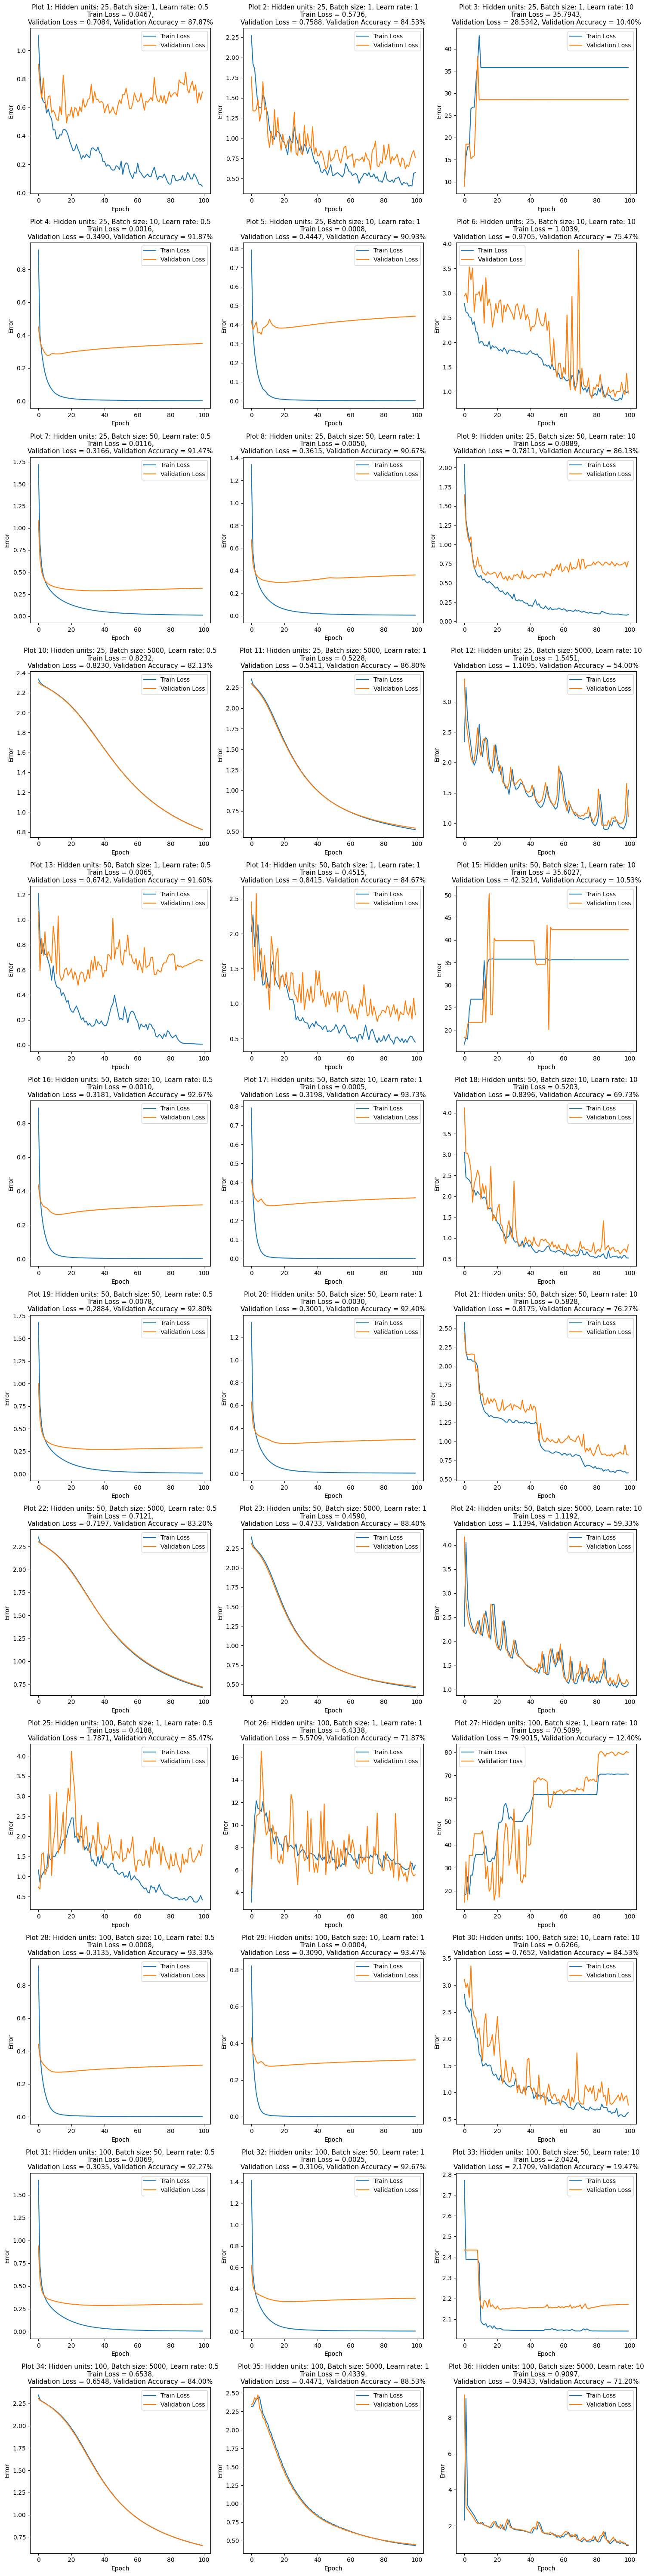

In [381]:
total_neural_nets = len(train_results)

num_cols = 3
num_rows = round(total_neural_nets / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()

for i, (_, model) in enumerate(train_results.items()):
	train_losses = model['train_losses']
	valid_losses = model['valid_losses']
	result_valid_loss = model['valid_losses'][-1]
	result_valid_accuracy = model['valid_accuracies'][-1]
	
	axes[i].plot(train_losses, label='Train Loss')
	axes[i].plot(valid_losses, label='Validation Loss')
	title = f'Plot {i + 1}: Hidden units: {model['num_hidden_units']}, Batch size: {model['batch_size']}, Learn rate: {model['learning_rate']}\nTrain Loss = {train_losses[-1]:.4f},\nValidation Loss = {result_valid_loss:.4f}, Validation Accuracy = {result_valid_accuracy * 100:.2f}%'
	axes[i].set_title(title, fontsize=11)
	axes[i].set_xlabel('Epoch')
	axes[i].set_ylabel('Error')
	axes[i].legend()

plt.tight_layout()
plt.savefig('plots/model_comparison_plot.png')
plt.show()

Como podemos ver dos multiplos plots, cada um tem resultados diferentes dependendo da sua combinação particular de hiperparâmetros.

## Encontrando o melhor resultado

Agora vamos verificar qual modelo obteve melhor resultado considerando acurácia de validação:

In [382]:
num_hidden_units, batch_size, learning_rate = max(train_results, key=lambda k: train_results[k]['valid_accuracies'][-1])
print(f'Number of hidden units = {num_hidden_units}\nBatch size = {batch_size}\nLearning rate = {learning_rate}')
best_result = train_results[(num_hidden_units, batch_size, learning_rate)]
print(f'Validation loss = {best_result['valid_losses'][-1]}')
print(f'Validation accuracy = {best_result['valid_accuracies'][-1] * 100:.2f}')

Number of hidden units = 50
Batch size = 10
Learning rate = 1
Validation loss = 0.319815186681808
Validation accuracy = 93.73


Agora vamos verificar qual modelo obteve melhor resultado considerando perda (loss) de validação:

In [383]:
num_hidden_units, batch_size, learning_rate = min(train_results, key=lambda k: train_results[k]['valid_losses'][-1])
print(f'Number of hidden units = {num_hidden_units}\nBatch size = {batch_size}\nLearning rate = {learning_rate}')
best_result = train_results[(num_hidden_units, batch_size, learning_rate)]
print(f'Validation loss = {best_result['valid_losses'][-1]}')
print(f'Validation accuracy = {best_result['valid_accuracies'][-1] * 100:.2f}')

Number of hidden units = 50
Batch size = 50
Learning rate = 0.5
Validation loss = 0.2883833241959413
Validation accuracy = 92.80


Como podemos ver, mesmo que o modelo com a menor perda de validação não tenha a maior acurácia de validação, ele ainda possui uma acurácia de validação muito próxima ao modelo com a maior acurácia de validação.

Isso acontece porque a função de perda mede tanto a correção quanto a confiança, penalizando mais severamente as previsões erradas e confiantes. A acurácia, por outro lado, conta apenas as previsões corretas e ignora os níveis de confiança. Como resultado, um modelo com previsões um pouco menos confiantes, mas mais corretas, pode ter uma perda menor, mas uma acurácia ligeiramente menor. Esse fenômeno se tornará ainda mais evidente quando analisarmos cada hiperparâmetro individualmente.

## Comparando hiperparâmetros individualmente

Agora, vamos comparar como os diferentes hiperparâmetros influenciam individualmente o desempenho do modelo.

Aqui criaremos uma função que será utilizado em todas as comparações:

In [384]:
def get_unique_hyper_params(train_results):
	unique_batch_sizes = []
	unique_learning_rates = []
	unique_num_hidden_units = []
	for (_, model) in train_results.items():
		if model['batch_size'] not in unique_batch_sizes:
			unique_batch_sizes.append(model['batch_size'])
		if model['learning_rate'] not in unique_learning_rates:
			unique_learning_rates.append(model['learning_rate'])
		if model['num_hidden_units'] not in unique_num_hidden_units:
			unique_num_hidden_units.append(model['num_hidden_units'])
	return unique_batch_sizes, unique_learning_rates, unique_num_hidden_units
	

### Comparando como o número de unidades ocultas influencia o desempenho do modelo

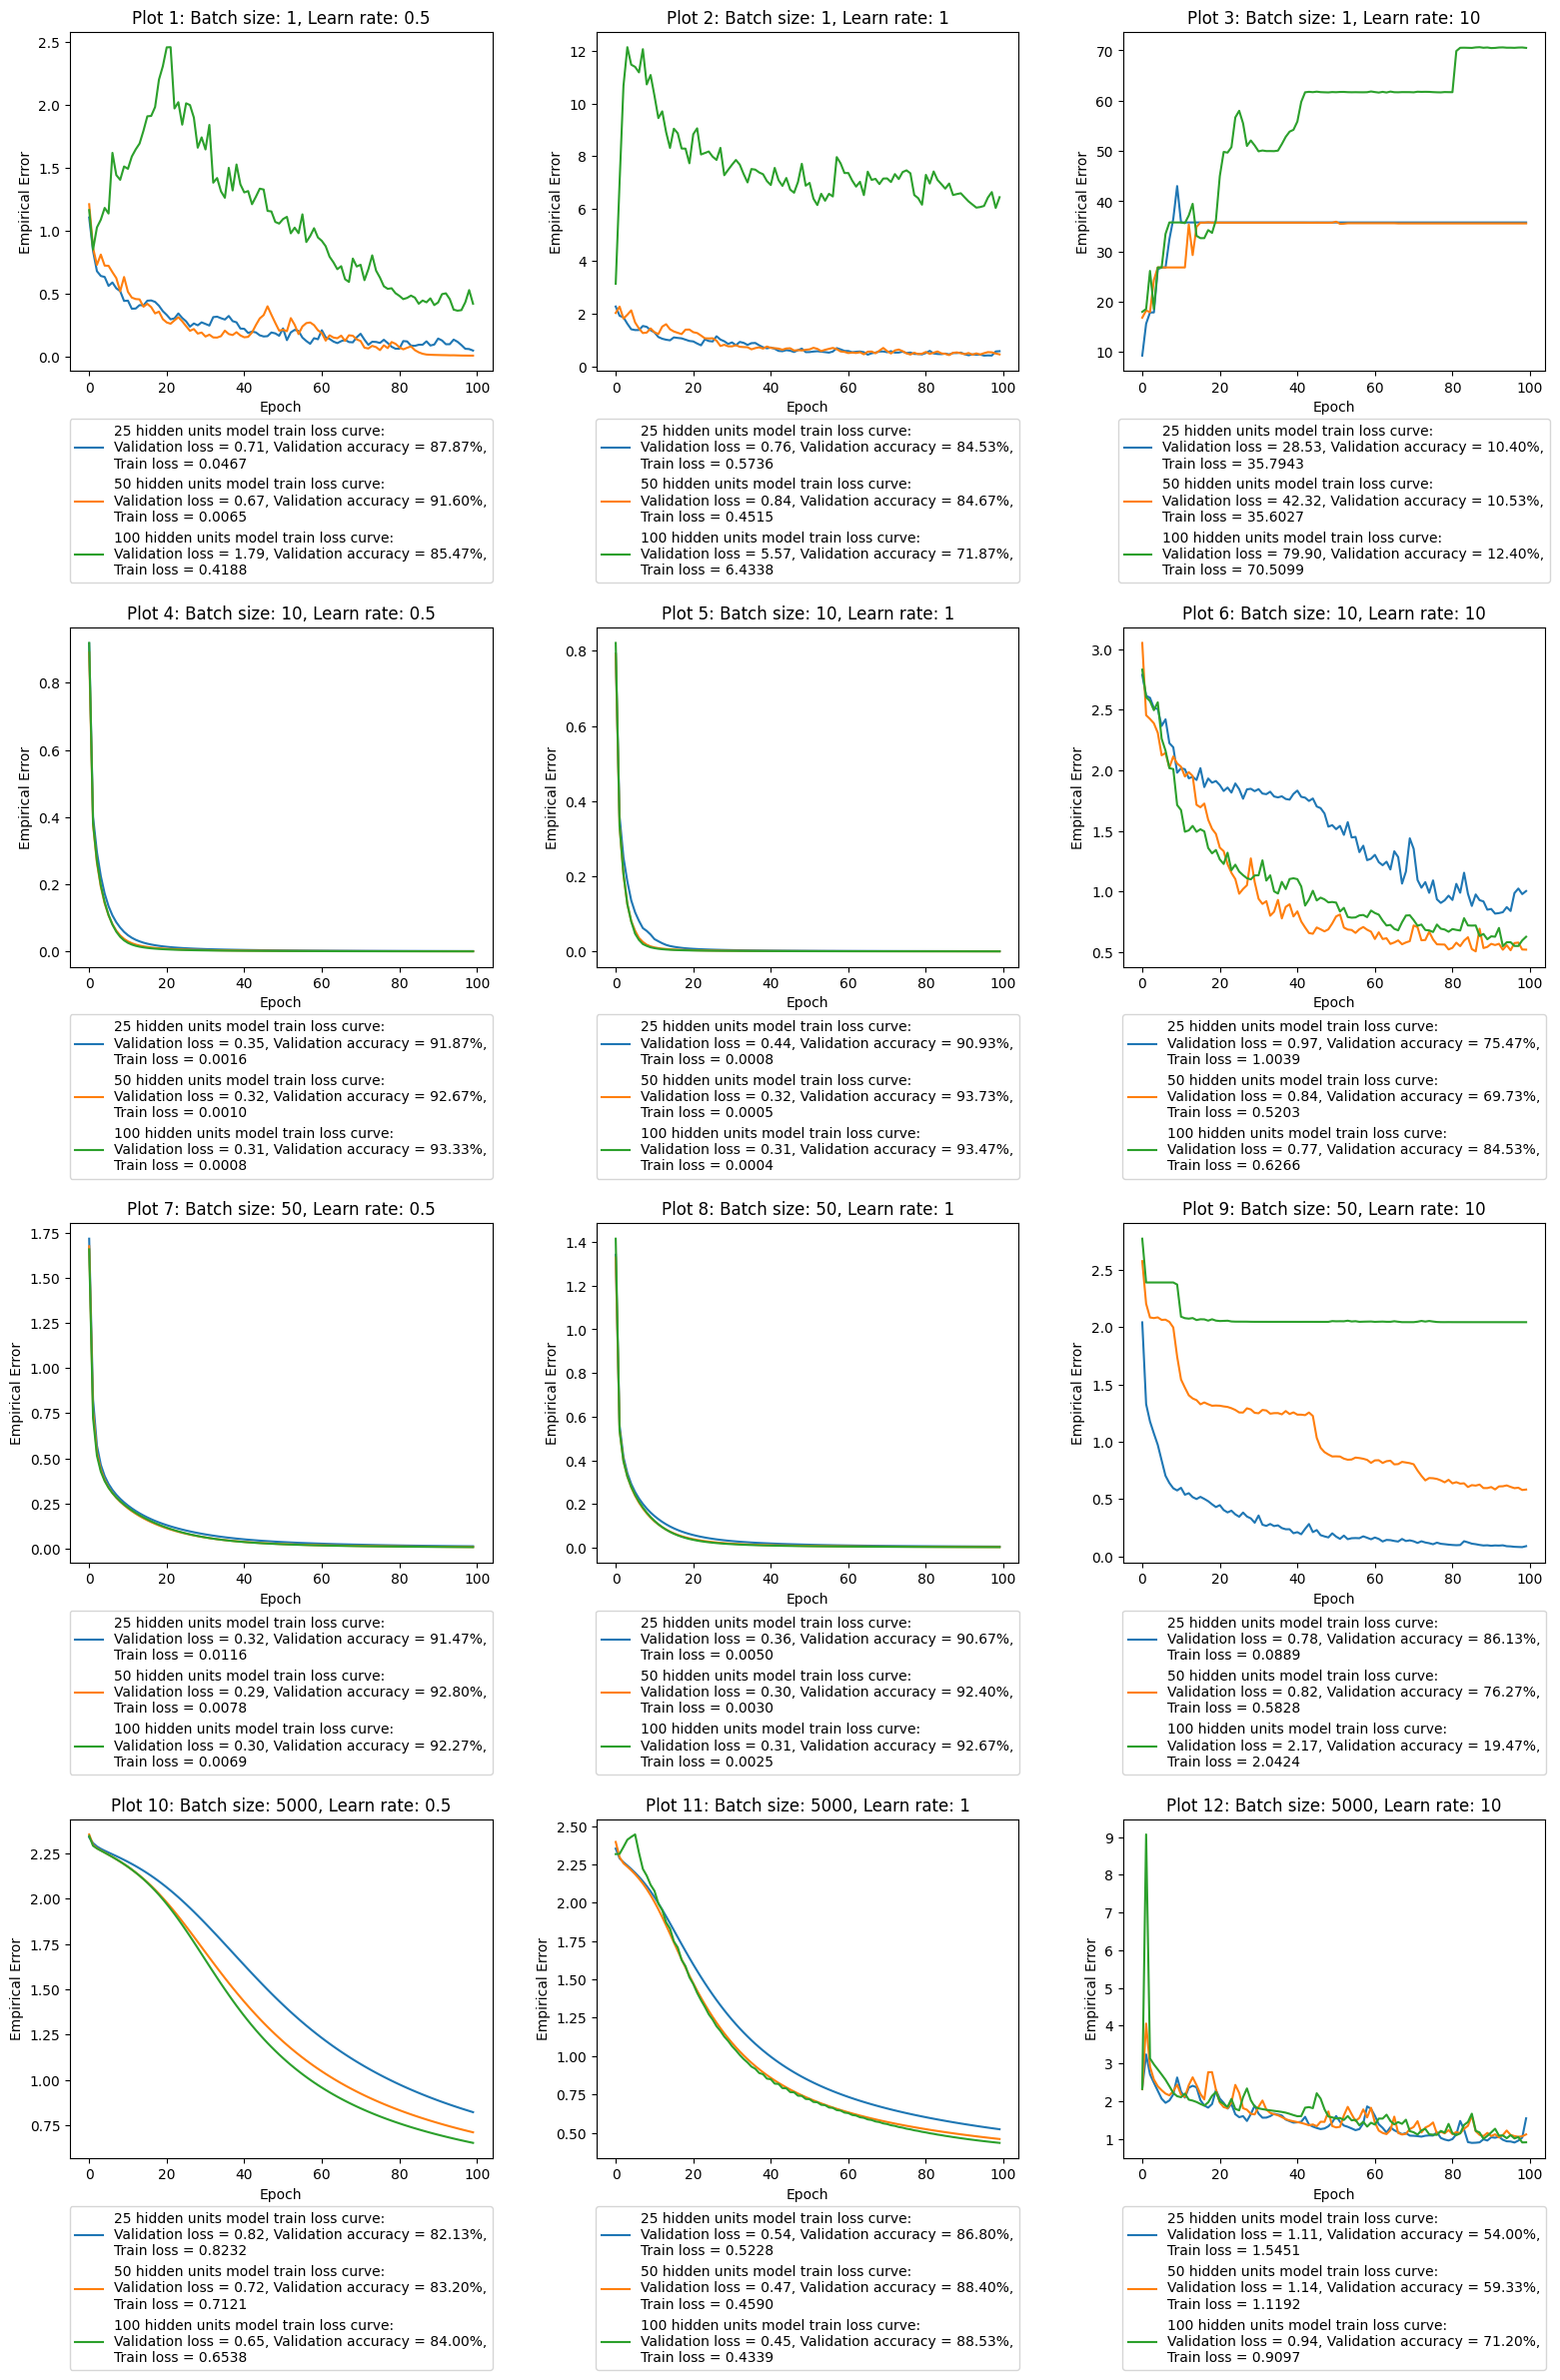

In [385]:
unique_batch_sizes, unique_learning_rates, unique_num_hidden_units = get_unique_hyper_params(train_results)

unique_partial_model_hyper_params = list(itertools.product(unique_batch_sizes, unique_learning_rates))

total_models = len(unique_partial_model_hyper_params)
num_cols = len(unique_learning_rates)
num_rows = round(total_models / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 6))
axes = axes.flatten()

for i, partial_model_hyper_params in enumerate(unique_partial_model_hyper_params):
	for num_hidden_units in unique_num_hidden_units:
		model = train_results[(num_hidden_units, ) + partial_model_hyper_params]
		label = f'{model['num_hidden_units']} hidden units model train loss curve:\nValidation loss = {model['valid_losses'][-1]:.2f}, Validation accuracy = {model['valid_accuracies'][-1] * 100:.2f}%,\nTrain loss = {model['train_losses'][-1]:.4f}'
		axes[i].plot(model['train_losses'], label=label)
	axes[i].set_title(f'Plot {i + 1}: Batch size: {model['batch_size']}, Learn rate: {model['learning_rate']}')
	axes[i].set_xlabel('Epoch')
	axes[i].set_ylabel('Empirical Error')
	axes[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=1, labelspacing=0.5)

plt.tight_layout()
plt.savefig('plots/hidden_units_comparison_plot.png')
plt.show()

Observe que, para os modelos com 100 unidades ocultas, a perda tende a ser baixa e a acurácia tende a ser alta quando o batch size é maior. No entanto, no caso em que o batch size é muito pequeno (b = 1), os modelos com 100 unidades ocultas não apresentam um bom desempenho. Isso ocorre devido à falta de épocas necessárias para aproximar corretamente uma solução ótima.

Em outra análise, os modelos com 25 unidades ocultas parecem ser menos sensíveis a batch sizes menores, porém, em geral, resultam em perdas ligeiramente maiores e acurácias ligeiramente menores quando comparados aos modelos com 50 e 100 unidades ocultas em média.

Portanto, um bom compromisso entre os modelos com 100 unidades ocultas, que possuem maior capacidade, mas são mais sensíveis aos batch sizes, e os modelos com 25 unidades ocultas, que tendem a ter um desempenho ligeiramente inferior, são os modelos com 50 unidades ocultas. Em geral, eles alcançam as maiores acurácias e as menores perdas, enquanto são robustos a mudanças em outros hiperparâmetros.

### Comparando como o batch size influencia o desempenho do modelo

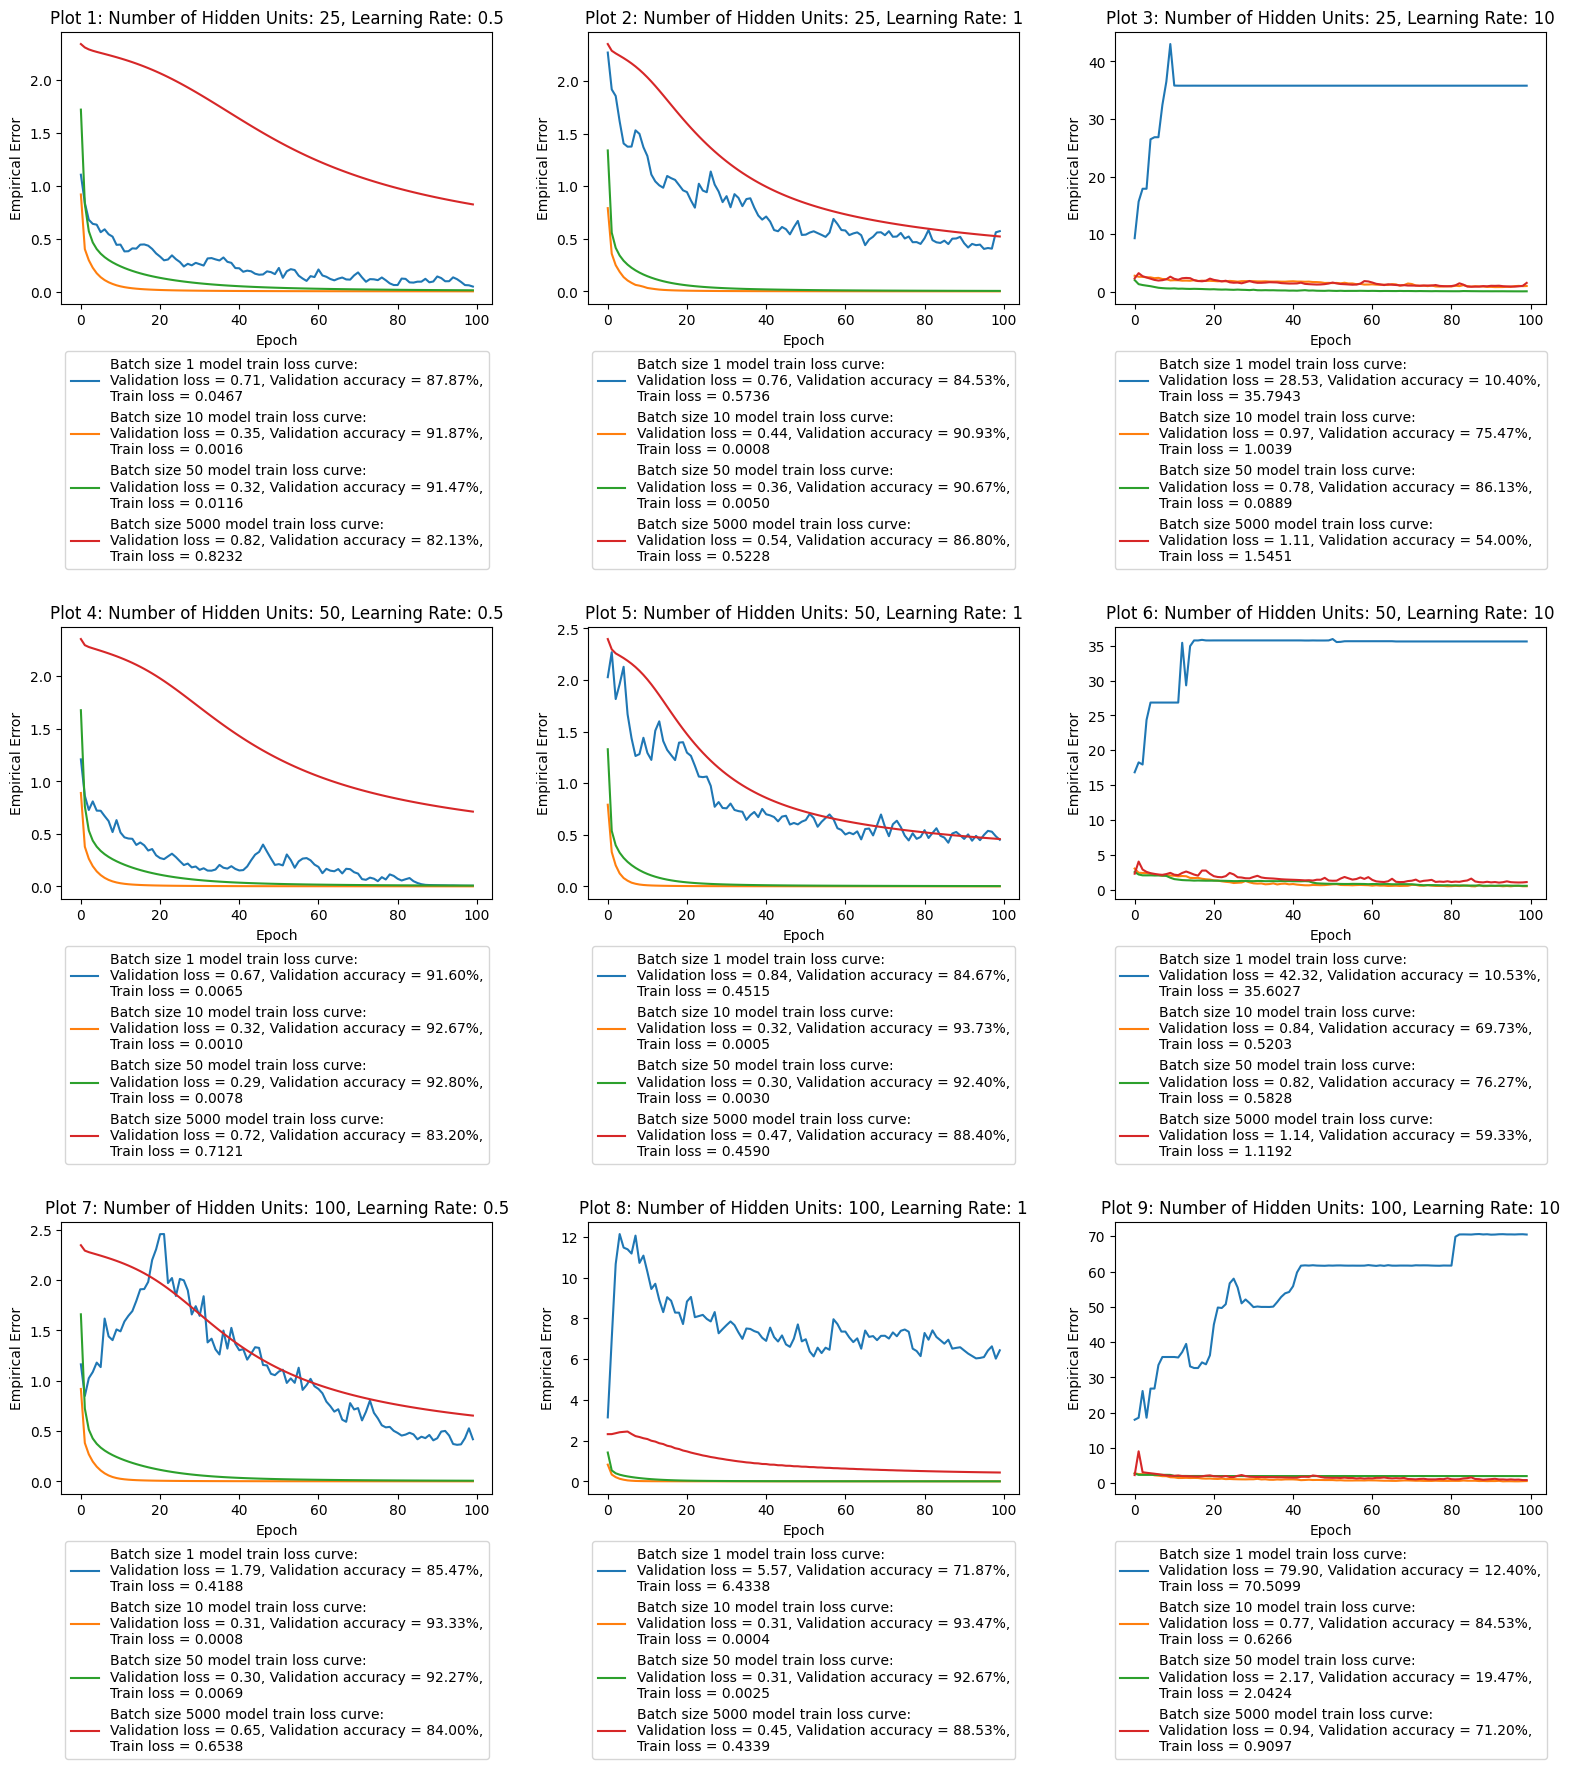

In [386]:
unique_batch_sizes, unique_learning_rates, unique_num_hidden_units = get_unique_hyper_params(train_results)

unique_partial_model_hyper_params = list(itertools.product(unique_num_hidden_units, unique_learning_rates))

total_models = len(unique_partial_model_hyper_params)
num_cols = len(unique_learning_rates)
num_rows = round(total_models / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 6))
axes = axes.flatten()

for i, partial_model_hyper_params in enumerate(unique_partial_model_hyper_params):
	for batch_size in unique_batch_sizes:
		num_hidden_units, learning_rate = partial_model_hyper_params
		model = train_results[(num_hidden_units, batch_size, learning_rate)]
		label = f'Batch size {model['batch_size']} model train loss curve:\nValidation loss = {model['valid_losses'][-1]:.2f}, Validation accuracy = {model['valid_accuracies'][-1] * 100:.2f}%,\nTrain loss = {model['train_losses'][-1]:.4f}'
		axes[i].plot(model['train_losses'], label=label)
	axes[i].set_title(f'Plot {i + 1}: Number of Hidden Units: {model['num_hidden_units']}, Learning Rate: {model['learning_rate']}')
	axes[i].set_xlabel('Epoch')
	axes[i].set_ylabel('Empirical Error')
	axes[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1, labelspacing=0.5)

plt.tight_layout()
plt.savefig('plots/batch_size_comparison_plot.png')
plt.show()

		


Observe que, para os modelos que têm grandes batch sizes (full batch com b = 5000), as perdas tendem a ser maiores e as acurácias menores, em comparação com outros modelos, quando a taxa de aprendizado é menor. Isso ocorre porque não há épocas suficientes para o modelo aprender. Portanto, uma alta taxa de aprendizado compensa isso, gerando resultados com menores perdas e maiores acurácias.

Em contraste, para os modelos com batch sizes pequenos (SGD com b = 1), as perdas tendem a ser menores e as acurácias maiores, em comparação com outros modelos, quando a taxa de aprendizado é menor. Isso evita o caso em que a descida do modelo é muito ruidosa durante o treinamento. No entanto, para modelos com mais unidades na camada oculta (100 unidades), isso não acontece devido à maior capacidade que exige mais treinamento para descer efetivamente para uma solução ótima.

Portanto, um bom compromisso seria escolher um batch size que não seja muito pequeno nem muito grande, como batch sizes de 50 ou 10 (Mini-Batch). Ambos esses batch sizes têm perdas e acurácias muito semelhantes (com exceção dos modelos com altas taxas de aprendizado). No entanto, geralmente os modelos com:
- Batch size de 50 possui:
    - Perdas ligeiramente menores
    - Com o trade-off de acurácias ligeiramente menores
- Enquanto o modelo com batch size de 10 possui:
    - acurácias ligeiramente maiores
    - Com o trade-off de perdas ligeiramente maiores
Em outras palavras, o modelo com batch size 50 é ligeiramente mais confiante, mas prevê corretamente menos, enquanto o modelo com batch size 10 é ligeiramente menos confiante, mas prevê corretamente mais. Dado que nosso modelo não depende fortemente de alta confiança (como modelos aplicados a diagnósticos médicos ou previsões financeiras), selecionaremos o modelo que é ligeiramente menos confiante, mas prevê corretamente mais (batch size 10) como nosso modelo ideal. Independentemente de escolhermos um batch size de 50 ou 10, o algoritmo Mini-Batch mostrou-se o mais adequado para nosso problema.

Portanto, estamos escolhendo o modelo que tende a uma maior acurácia, em vez de uma menor perda. Essa decisão será refletida ao analisar a taxa de aprendizado.

### Comparando como a taxa de aprendizado influencia o desempenho do modelo

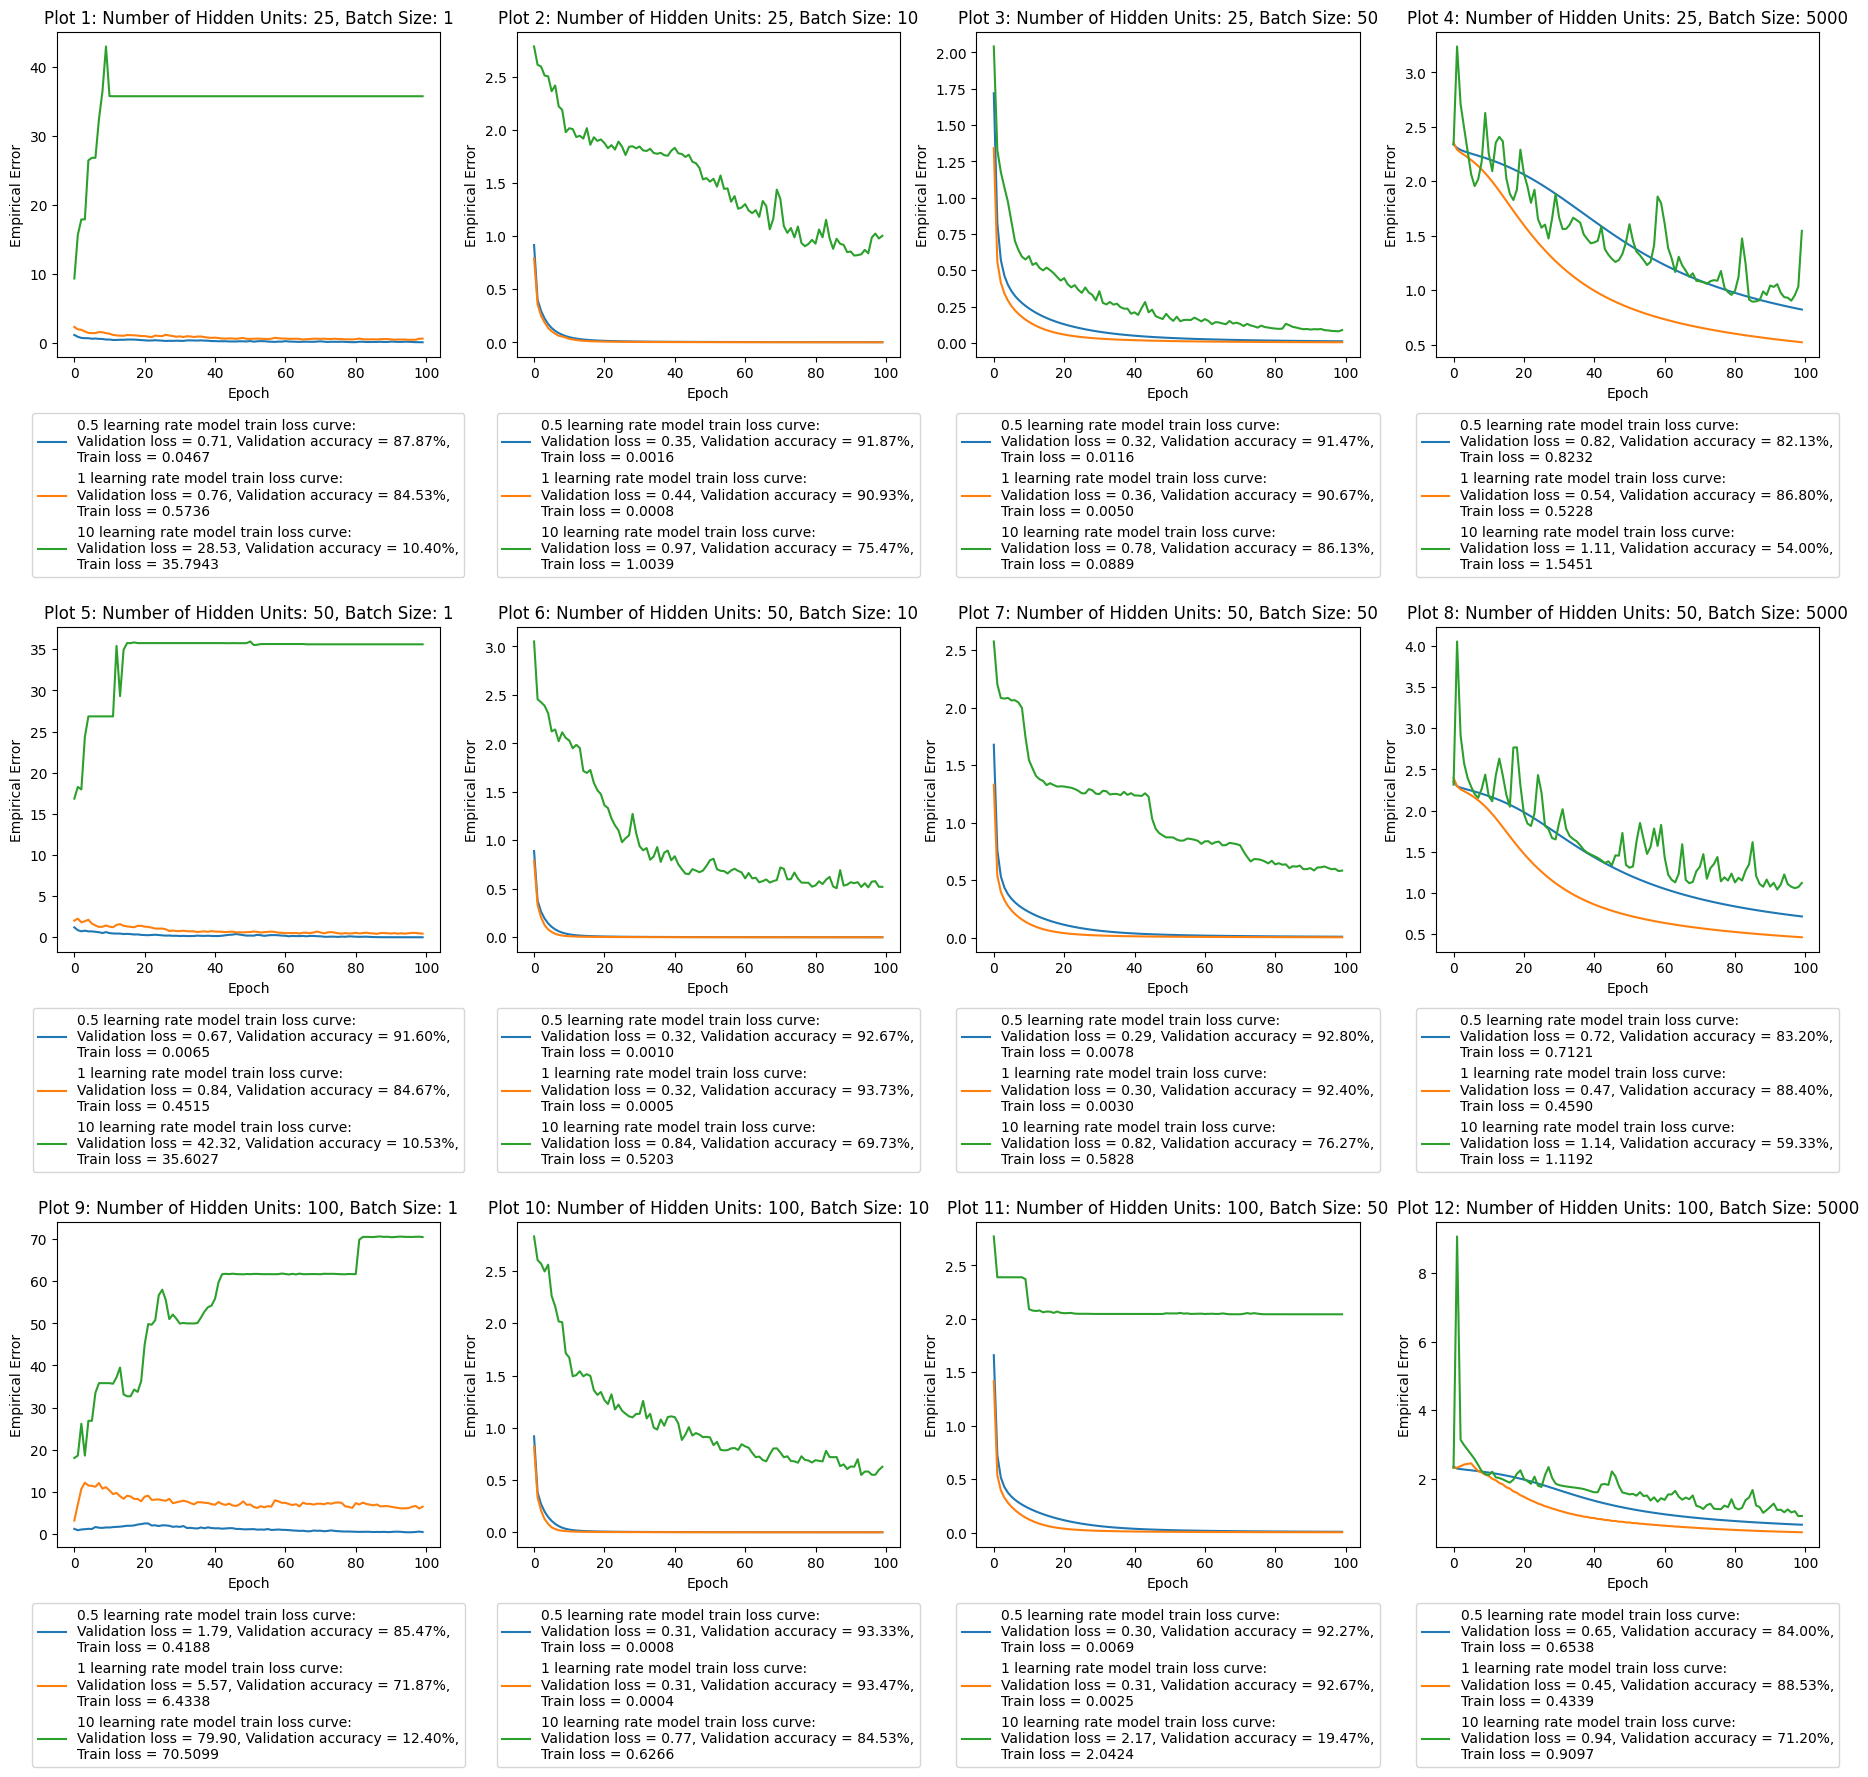

In [387]:
unique_batch_sizes, unique_learning_rates, unique_num_hidden_units = get_unique_hyper_params(train_results)

unique_partial_model_hyper_params = list(itertools.product(unique_num_hidden_units, unique_batch_sizes))

total_models = len(unique_partial_model_hyper_params)
num_cols = len(unique_batch_sizes)
num_rows = round(total_models / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(19, num_rows * 6))
axes = axes.flatten()

for i, partial_model_hyper_params in enumerate(unique_partial_model_hyper_params):
	for learning_rate in unique_learning_rates:
		num_hidden_units, batch_size = partial_model_hyper_params
		model = train_results[(num_hidden_units, batch_size, learning_rate)]
		label = f'{model['learning_rate']} learning rate model train loss curve:\nValidation loss = {model['valid_losses'][-1]:.2f}, Validation accuracy = {model['valid_accuracies'][-1] * 100:.2f}%,\nTrain loss = {model['train_losses'][-1]:.4f}'
		axes[i].plot(model['train_losses'], label=label)
	axes[i].set_title(f'Plot {i + 1}: Number of Hidden Units: {model['num_hidden_units']}, Batch Size: {model['batch_size']}')
	axes[i].set_xlabel('Epoch')
	axes[i].set_ylabel('Empirical Error')
	axes[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1, labelspacing=0.5)

plt.tight_layout()
fig.subplots_adjust(wspace=0.2)
plt.savefig('plots/learning_rate_comparison_plot.png')
plt.show()	

		


Como é claramente visto em todos os gráficos, taxas de aprendizado altas (lr = 10) penalizam fortemente o modelo com uma descida ruidosa ou divergindo completamente. Isso é atenuado quando o batch size é muito grande (full batch com b = 5000) devido ao fato de que o baixo número de épocas recompensa taxas de aprendizado mais altas para chegar mais rapidamente à solução ótima.

Em batch sizes grandes (full batch com b = 5000), o desempenho dos modelos com taxas de aprendizado mais altas (lr = 10) é melhor devido ao motivo explicado acima. No entanto, para batch sizes pequenos (SGD com b = 1), ocorre o inverso devido à taxa de aprendizado mais baixa atenuando a descida ruidosa de um batch size de 1. Independentemente do batch size, taxas de aprendizado de 0,5 e 1 são muito melhores para descer até a solução ótima.

Em contraste, para batch sizes médios (Mini-Batch com b = 10 ou b = 50) as taxas de aprendizado de 0,5 e 1 apresentam perdas e acurácias semelhantes. Portanto, dado que optamos por preferir modelos que tenham acurácias mais altas do que perdas mais baixas, selecionaremos a taxa de aprendizado de 1 como a ótima.

## Retreinando o modelo com melhor performance

Dado a nossa análise, determinamos que o melhor modelo para o nosso caso de uso foi o modelo com os seguinte hiperparâmetros:
- 50 unidades ocultas
- Batch size de 10 (Mini-Batch)
- Taxa de aprendizado de 1

Portante, nós iremos retreinar esse modelo ótimo nos dados de treino e validação combinados

In [ ]:
best_num_hidden_units, best_batch_size, best_learning_rate = max(train_results, key=lambda k: train_results[k]['valid_accuracies'][-1])

best_model = NeuralNetwork(784, best_num_hidden_units, 10)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(best_model.parameters(), lr=best_learning_rate)
train_and_valid_dataset = ConcatDataset([train_dataset, valid_dataset])
train_and_valid_dataloader = DataLoader(train_and_valid_dataset, batch_size=best_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=True)
num_epochs = 100
train_losses, test_losses, test_accuracies = train_neural_net(best_model, train_and_valid_dataloader, loss_func, optimizer, num_epochs, test_dataloader)

best_train_result = {
	'num_hidden_units': best_num_hidden_units,
	'batch_size': best_batch_size,
	'learning_rate': best_learning_rate,
	'train_losses': train_losses,
	'test_losses': test_losses,
	'test_accuracies': test_accuracies
}

with open("results/2best_train_result.pkl", "wb") as f:
	pickle.dump(best_train_result, f) 

## Resultados finais

Agora vamos plotar os resultados para o modelo ótimo retreinado e avaliar sua performance:

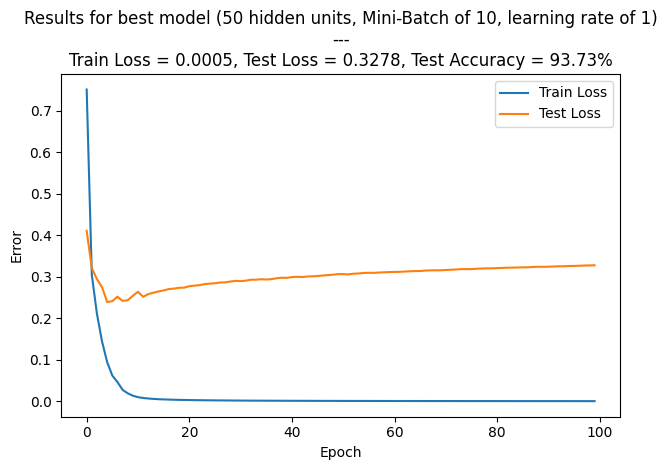

In [389]:
with open("results/best_train_result.pkl", "rb") as f:
	best_train_result = pickle.load(f)

train_losses = best_train_result['train_losses']
test_losses = best_train_result['test_losses']
test_accuracies = best_train_result['test_accuracies']
best_num_hidden_units = best_train_result['num_hidden_units']
best_batch_size = best_train_result['batch_size']
best_learning_rate = best_train_result['learning_rate']

plt.plot(train_losses, label=f'Train Loss')
plt.plot(test_losses, label=f'Test Loss')
plt.title(f'Results for best model ({best_num_hidden_units} hidden units, Mini-Batch of {best_batch_size}, learning rate of {best_learning_rate})\n---\nTrain Loss = {train_losses[-1]:.4f}, Test Loss = {test_losses[-1]:.4f}, Test Accuracy = {test_accuracies[-1] * 100:.2f}%')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.tight_layout()
plt.savefig('plots/best_model_plot.png')
plt.show()

Como podemos ver em nossos resultados, o modelo selecionado apresenta alta acurácia de teste (93,73%) e baixa perda (perda de teste = 0,3278 e perda de treino = 0,0005). Isso se deve à seleção ótima de hiperparâmetros:
- Uma capacidade intermediária (50 unidades ocultas), que evita:
    - Desempenho ligeiramente inferior devido ao tamanho menor do conjunto de dados ao usar o modelo de 100 unidades
    - Desempenho inferior do modelo de 25 unidades devido à menor capacidade de aprendizado
- Um batch size intermediário (Mini-Batch de 10), que evita:
    - Uma descida muito ruidosa ao usar batch sizes menores (SGD)
    - Um modelo que generaliza menos devido à ausência de ruído na descida ao usar batch sizes grandes (full batch)
- Uma taxa de aprendizado intermediária (lr = 1), que evita:
    - Atualizações que divergem ao invés vez de convergirem para o ótimo em taxas de aprendizado altas (lr = 10)
    - Atualizações que convergem de forma ligeiramente mais lenta
Portanto, podemos concluir a importância de testar diferentes hiperparâmetros para garantir a seleção de um modelo com desempenho ótimo.